In [1]:
from IPython.display import display
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import math

from sklearn import linear_model
from scipy import stats as scipystats
from scipy.stats import norm, kstest, boxcox
import statsmodels.api as sm
import statsmodels.stats as stats
import statsmodels.formula.api as smf

# Display preferences.
pd.options.display.float_format = '{:.3f}'.format

# plt.rcParams['figure.figsize'] = (50.0, 20.0)
# plt.rcParams.update({'font.size': 22})

import warnings
# Suppress annoying harmless errors
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
df = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(df.head())

# Instantiate and fit model.
regr = linear_model.LinearRegression()
Y = df.Sales.values.reshape(-1, 1)
X = df[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Review the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### Multivariate Normality

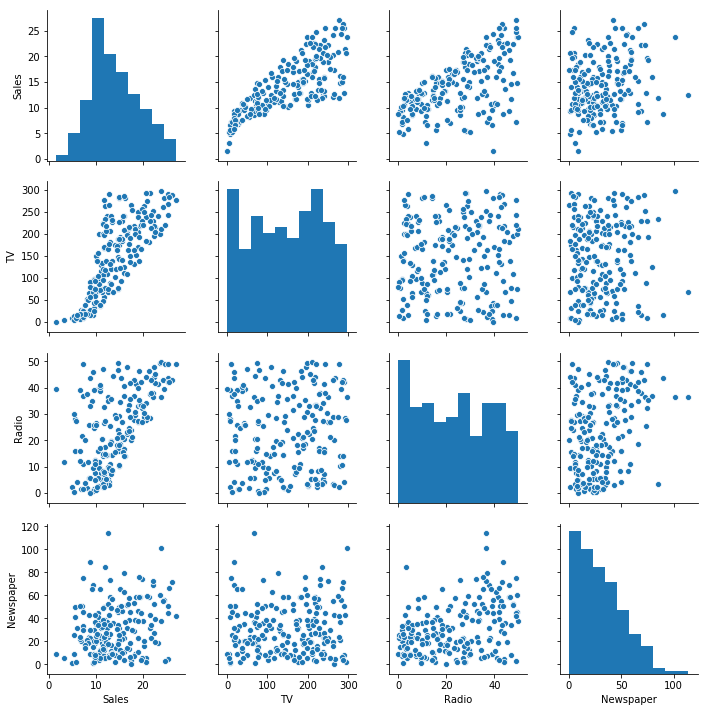

In [3]:
sns.pairplot(df[['Sales', 'TV', 'Radio', 'Newspaper']].dropna(how = 'any', axis = 0))
plt.show()

In [4]:
# Ordinary Least Squares formula - dependent variable comes before the "~", then each independent variable
# https://stackoverflow.com/questions/30650257/ols-using-statsmodel-formula-api-versus-statsmodel-api
# http://songhuiming.github.io/pages/2016/12/31/linear-regression-in-pytdfn-chapter-2/

lm_1 = smf.ols(formula = "Sales ~ TV + Radio + Newspaper", data = df).fit()
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 13 Nov 2018   Prob (F-statistic):           1.58e-96
Time:                        09:05:49   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

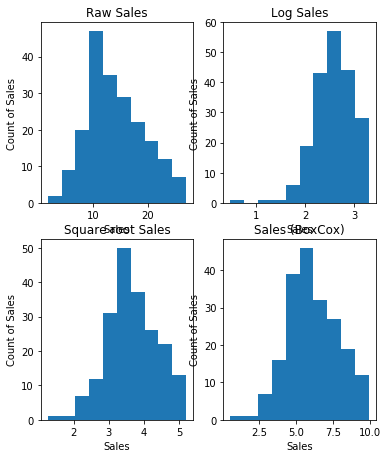

In [5]:
# Checking out the distribution of the independent variable: TV
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=-.5, right=None, top=None, wspace=None, hspace=None)

fig.add_subplot(221)
plt.hist(df.Sales)
plt.title('Raw Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

fig.add_subplot(222)
plt.hist(np.log(df.Sales))
plt.title('Log Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

fig.add_subplot(223)
plt.hist(np.sqrt(df.Sales.replace(0, np.nan).dropna()))
plt.title('Square root Sales')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

ax3=fig.add_subplot(224)
# Box Cox Transformation:
# http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html

transform_sales = np.asarray(df[['Sales']].values)

# transform values and store as "sales_boxcox"
Sales_boxcox = boxcox(transform_sales)[0]

# create the boxcox_sales transformed variable:
df['Sales_boxcox'] = Sales_boxcox

# plot the transformed box cox data
plt.hist(Sales_boxcox)
plt.title('Sales (BoxCox)')
plt.xlabel('Sales')
plt.ylabel('Count of Sales')

plt.show()

In [6]:
print('Shapiro Test for Sales (Dependent Variable):')
print()
print('Log:         ', scipystats.shapiro(np.log(df.Sales)))
print('Square Root: ', scipystats.shapiro(np.sqrt(df.Sales)))
print('Box Cox:     ', scipystats.shapiro(df.Sales_boxcox))
print()
print('The Box Cox Transformation is the most normal of the three (largest W statistic/score)')
print()
print('1st number = W statistic. Want the largest W.')
print()
print('2nd number = P-value. Want > .05 (otherwise, indicates a significant difference)')

Shapiro Test for Sales (Dependent Variable):

Log:          (0.9519966244697571, 2.953277544293087e-06)
Square Root:  (0.9888856410980225, 0.12231794744729996)
Box Cox:      (0.9892246723175049, 0.13737188279628754)

The Box Cox Transformation is the most normal of the three (largest W statistic/score)

1st number = W statistic. Want the largest W.

2nd number = P-value. Want > .05 (otherwise, indicates a significant difference)


### Homoscedasticity

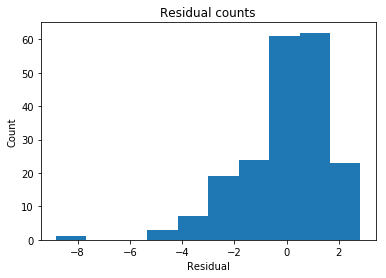

In [7]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning. Left skewed (based on tail)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#### Residuals Scatter Plot

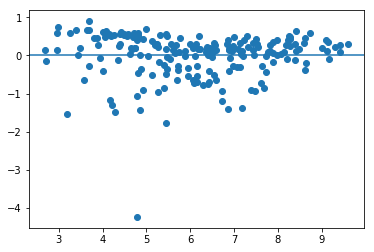

In [8]:
lm_2 = smf.ols(formula = "Sales_boxcox ~ TV + Radio", data = df).fit()

resid_2 = lm_2.resid
plt.axhline(y=0)
plt.scatter(lm_2.predict(), resid_2);

In [9]:
print('TV data describe:')
print(df.TV.describe())
print()

print('Radio data describe:')
print(df.Radio.describe())

TV data describe:
count   200.000
mean    147.042
std      85.854
min       0.700
25%      74.375
50%     149.750
75%     218.825
max     296.400
Name: TV, dtype: float64

Radio data describe:
count   200.000
mean     23.264
std      14.847
min       0.000
25%       9.975
50%      22.900
75%      36.525
max      49.600
Name: Radio, dtype: float64


In [10]:
print('Smallest 5 TV values:')
print(df.TV.nsmallest(5))
print()
print('Largest 5 TV values:')
print(df.TV.nlargest(5))

print()
print('Smallest 5 Radio values:')
print(df.Radio.nsmallest(5))
print()
print('Largest 5 Radio values:')
print(df.Radio.nlargest(5))

Smallest 5 TV values:
130   0.700
155   4.100
78    5.400
56    7.300
126   7.800
Name: TV, dtype: float64

Largest 5 TV values:
101   296.400
42    293.600
30    292.900
35    290.700
98    289.700
Name: TV, dtype: float64

Smallest 5 Radio values:
127   0.000
107   0.300
108   0.400
117   0.800
157   1.300
Name: Radio, dtype: float64

Largest 5 Radio values:
58    49.600
37    49.400
55    49.400
128   49.000
147   49.000
Name: Radio, dtype: float64


In [11]:
# Create variables to remove outliers in independent variables: remove all values 
# below the .5% of values in that column 
tv_min = df[(df['TV'] < np.percentile(df['TV'],.5))]
radio_min = df[(df['Radio'] < np.percentile(df['Radio'],.5))]

In [12]:
# Remove min from TV and Radio
df = df.replace(0, np.nan).dropna()
df = df.replace(tv_min, np.nan).dropna()
df = df.replace(radio_min, np.nan).dropna()

# get minimum value row for TV
print('TV min:')
print(df.loc[df['TV'].idxmin()])
print()
print('Radio min:')
print(df.loc[df['Radio'].idxmin()])

# drop min values for features

TV min:
Unnamed: 0     156.000
TV               4.100
Radio           11.600
Newspaper        5.700
Sales            3.200
Sales_boxcox     1.659
Name: 155, dtype: float64

Radio min:
Unnamed: 0     108.000
TV              90.400
Radio            0.300
Newspaper       23.200
Sales            8.700
Sales_boxcox     4.310
Name: 107, dtype: float64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 198
Data columns (total 6 columns):
Unnamed: 0      194 non-null float64
TV              194 non-null float64
Radio           194 non-null float64
Newspaper       194 non-null float64
Sales           194 non-null float64
Sales_boxcox    194 non-null float64
dtypes: float64(6)
memory usage: 15.6 KB


In [14]:
# def WinsorizeCustom(data):
#     quantiles = data.quantile([0.1, 1])
#     q_01 = quantiles.loc[0.1]
#     q_1 = quantiles.loc[1]

#     out = np.where(data.values <= q_01,q_01, 
#                                       np.where(data >= q_1, q_1, data)
#                   )
#     return out

In [15]:
# # Winsor to remove outliers
# df.TV = WinsorizeCustom(df.TV)
# df.Radio = WinsorizeCustom(df.Radio)

                            OLS Regression Results                            
Dep. Variable:           Sales_boxcox   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     951.4
Date:                Tue, 13 Nov 2018   Prob (F-statistic):          4.89e-100
Time:                        09:06:02   Log-Likelihood:                -144.11
No. Observations:                 194   AIC:                             294.2
Df Residuals:                     191   BIC:                             304.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4965      0.091     27.317      0.0

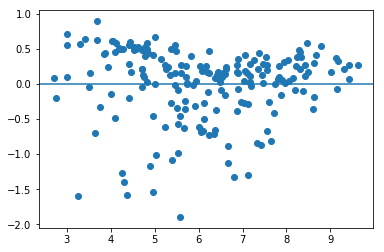

In [16]:
lm_3 = smf.ols(formula = "Sales_boxcox ~ TV + Radio", data = df).fit()
print(lm_3.summary())

resid_3 = lm_3.resid
plt.axhline(y=0)
plt.scatter(lm_3.predict(), resid_3);

In [17]:
print('Smallest 5 TV values:')
print(df.TV.nsmallest(5))
print()
print('Largest 5 TV values:')
print(df.TV.nlargest(5))

print()
print('Smallest 5 Radio values:')
print(df.Radio.nsmallest(5))
print()
print('Largest 5 Radio values:')
print(df.Radio.nlargest(5))

Smallest 5 TV values:
155   4.100
78    5.400
56    7.300
126   7.800
132   8.400
Name: TV, dtype: float64

Largest 5 TV values:
101   296.400
42    293.600
30    292.900
35    290.700
98    289.700
Name: TV, dtype: float64

Smallest 5 Radio values:
107   0.300
108   0.400
117   0.800
157   1.300
34    1.400
Name: Radio, dtype: float64

Largest 5 Radio values:
58    49.600
37    49.400
55    49.400
128   49.000
147   49.000
Name: Radio, dtype: float64
